<a href="https://colab.research.google.com/github/Jagdish05/Assistnet/blob/main/AssistNet_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing All the libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import preprocessing
from itertools import cycle
from itertools import chain
from scipy import stats

import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import math
import os
import time
from tensorflow.keras.models import load_model

from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Flatten, Dense,MaxPooling2D ,Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')
print('Keras Version', keras.__version__)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIME_PERIOD = 80
WINDOW = 40
# originally used to fine tune the values, but that is now being done in a loop with several different dimension sizes.
tuner = 1

Keras Version 2.4.0


In [ ]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [ ]:
def show_basic_dataframe(dataframe):
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i' % (dataframe.shape[0]))

In [ ]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10), sharex=True)

    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    fig.savefig(activity+'_x-y-z-axis')
    plt.show()

In [ ]:
def plot_axis(ax,x,y,title):
    ax.plot(x,y,'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y)-np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

# Reading all accelarotmeter data of phone from the directory and saving it to one dataframe

In [ ]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)

    df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0,how='any',inplace=True)
    return df


In [ ]:
def read_dir(dir_path):
    df = []
    for f_name in os.listdir(dir_path):
        if f_name.endswith('.txt'):
            df1= read_data(dir_path+f_name)
            df.append(df1)

    return df

In [ ]:
# df_full = read_dir("D:\\Courses\\AI-wearable\\Assignment 1\\wisdm-dataset\\wisdm-dataset\\raw\\phone\\accel\\")

In [ ]:
# #df= pd.concat(df_full)
# print(df.head())
# df.shape

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of columns in the dataframe: 7
Number of rows in the dataframe: 4804403
    Unnamed: 0  user-id activity        timestamp  x-axis  y-axis  z-axis
0            0     1600  walking  252207666810782    -0.4     8.8     1.1
1            1     1600  walking  252207717164786    -0.9     9.8     1.0
2            2     1600  walking  252207767518790     2.0    11.1     2.6
3            3     1600  walking  252207817872794     0.5    12.7     0.2
4            4     1600  walking  252207868226798    -2.2    13.9    -4.4
5            5     1600  walking  252207918580802    -4.3    13.4    -0.7
6            6     1600  walking  252207968934806    -0.3    13.3    -0.2
7            7     1600  walking  252208019288809     1.6     9.5    -0.0
8            8     1600  walking  252208069642813    -0.3     5.3     0.3
9            9     1600  walking  252208119996817    -1.8     3.7     1.4
10          10     1600  walking  252208170350821    -1.1     4.5     2.3
11          11     1600  walking 

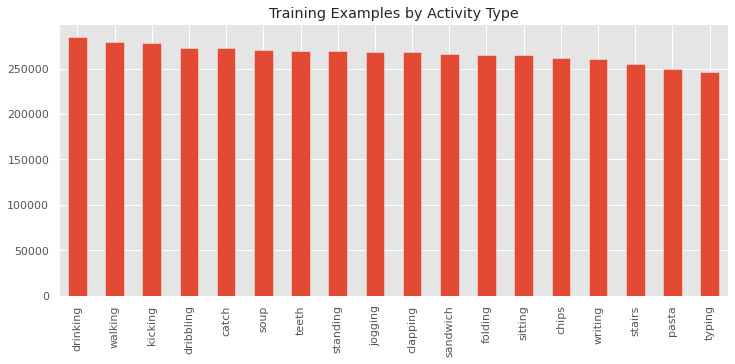

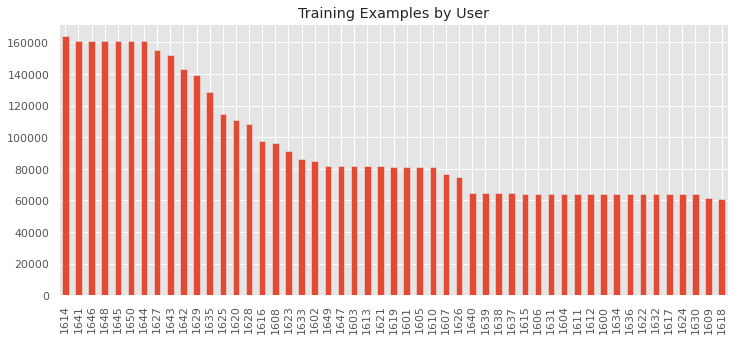

In [ ]:
#df.to_csv('full_dataset_with_18_act.csv')
df = pd.read_csv('/content/drive/My Drive/WAI P3/Project 3 /full_dataset_with_18_act.csv')
#df = pd.read_csv('/content/drive/My Drive/full_dataset_with_18_act.csv')

# Replacing Activity Symbols to its name.
activity_sym = ['A','B','C','D','E','F','G','H','I','J','K','L','M','O','P','Q','R','S']
activity_name = ['walking','jogging','stairs','sitting','standing','typing','teeth','soup','chips','pasta','drinking','sandwich','kicking','catch','dribbling','writing','clapping','folding']
for x,y in zip(activity_sym,activity_name):
  df = df.replace(to_replace = [x], value = y)

show_basic_dataframe(df)
print(df.head(20))
fig = plt.figure(figsize=(12,5))

df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()
fig = plt.figure(figsize=(12,5))
fig.savefig('trainingexamplebyacitivty.png')
df['user-id'].value_counts().plot(kind='bar',title='Training Examples by User')

plt.show()
fig.savefig('trainingexamplesbyusers.png')

# Label Encoding and Segmenting

In [ ]:
def labelenocoder(df_label):
    for activity in np.unique(df_label['activity']):
        subset = df_label[df_label['activity'] == activity][:180]
        plot_activity(activity,subset)

    LABEL = 'ActivityEncoded'
    le = preprocessing.LabelEncoder()

    df_label[LABEL] = le.fit_transform(df_label['activity'].values.ravel())
    return le

In [ ]:
def create_segments_and_labels(df, time_steps, step, label_names):
    FEATURES = 3

    segments = []
    labels = []

    for i in range(0,len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        label = stats.mode(df[label_names][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# Spliting Dataset and Model Design

In [ ]:
def spliting_dataset(df_base):
    df_test = df_base[df_base['user-id'] > 1617 ]
    df_train = df_base[df_base['user-id'] <= 1617 ]
    # df_train = df_base

    pd.options.mode.chained_assignment = None
    df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
    df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
    df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
    #new Normalization attemp P3 loss: 0.5246 - accuracy: 0.7787 - val_loss: 0.5878 
    # df_train['x-axis'] = (df_train['x-axis'] -  df_train['x-axis'].min())  / (df_train['x-axis'].max() - df_train['x-axis'].min())
    # df_train['y-axis'] = (df_train['y-axis']  - df_train['y-axis'].min()) / (df_train['y-axis'].max() - df_train['y-axis'].min())
    # df_train['z-axis'] = (df_train['z-axis']  - df_train['z-axis'].min()) / (df_train['z-axis'].max() - df_train['z-axis'].min())


    df_train = df_train.round({'x-axis': 4, 'y-axis':4, 'z-axis': 4})

    
    X_train, y_train = create_segments_and_labels(df_train, TIME_PERIOD, WINDOW, LABEL)

    print('X_train Shape:', X_train.shape)
    print(X_train.shape[0], 'training samples')
    print('y_train shape: ', y_train.shape)
    input_shape = (80*3)
    x_train = X_train.reshape(X_train.shape[0], input_shape)
    # print('x_train shape:', x_train)
    print('input_shape:', input_shape)
    samps, secs, accel = X_train.shape
    red_dim = secs * accel
    
    return X_train,y_train
    

In [ ]:
def fit_model(X_train, y_train, X_val, y_val,epochs =5,learning_rate=0.001):
    # Lerining rate = 0.0001 loss: 0.2400 - accuracy: 0.9032 - val_loss: 0.2778
    # learning rate = 0.01 loss: 0.2223 - accuracy: 0.9121 - val_loss: 0.2334 
    # define model
    # swish activation function in first 2 layers(learning rate = 0.0001) : loss: 0.3869 - accuracy: 0.8425 - val_loss: 0.4136 - val_accuracy: 0.8745
    # swish activation function in first 3 layers(learning rate = 0.001) : loss: 0.3940 - accuracy: 0.8400 - val_loss: 0.6777 - val_accuracy: 0.8346
    #  swish activation function in first 2 layers(learning rate = 0.001) : loss: 0.4101 - accuracy: 0.8298 - val_loss: 0.7192 - val_accuracy: 0.8225
    # batch size 128(150 epochs) loss: 0.1345 - accuracy: 0.9485 - val_loss: 0.1984 - val_accuracy: 0.9494
    # batch size 64(150 epochs) loss: 0.1154 - accuracy: 0.9546 - val_loss: 0.2041 - val_accuracy: 0.9620
    # batch size 128(300 epochs) loss: 0.0996 - accuracy: 0.9585 - val_loss: 0.2534 - val_accuracy: 0.9541
    # batch size 64(300 epochs) loss: 0.1112 - accuracy: 0.9539 - val_loss: 0.2845 - val_accuracy: 0.9573
    # batch size 128(400 epochs) loss: 0.0824 - accuracy: 0.9667 - val_loss: 0.2748 - val_accuracy: 0.9595
    # batch size 128(500 epochs) loss: 0.0590 - accuracy: 0.9756 - val_loss: 0.3083 - val_accuracy: 0.9641
    # batch size 128(1000 epochs) loss: 0.0367 - accuracy: 0.9841 - val_loss: 0.3189 - val_accuracy: 0.9709
    
    model = Sequential()
    model.add(Conv2D(64, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
    # model1.add(MaxPooling2D(pool_size=(2,2),strides=(1, 1),padding='valid'))

    model.add(Dropout(0.1))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    
    # new changes in the model for layers 
    #model.add(Conv2D(128, (2, 2), activation='relu'))
    # until here 
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))


    model.add(Dense(9, activation='softmax'))
    # compile model
    model.compile(optimizer=Adam(learning_rate = learning_rate,decay = 1e-6), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
    import time
    start = time.time()
    # fit model
    history = model.fit(X_train, y_train, epochs = epochs, validation_data= (X_val, y_val), verbose=1,batch_size = 128)
    stop = time.time()
    duration = stop - start
    return model,history,duration

# Evaluating model by training full

In [ ]:
def eval_standalone_model(X_train, X_test, y_train, y_test, X_val, y_val , n_repeats):
    scores = list()
    times = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        start = time.time()
        model,history,duration = fit_model(X_train, y_train,X_val, y_val)
        # evaluate model on test dataset
        stop = time.time()
        _, test_acc = model.evaluate(X_test, y_test, verbose=0)
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times

# Evaluating model according to layers want to fixed

In [ ]:
def eval_transfer_model(X_train, X_test, y_train, y_test, n_fixed, n_repeats):
    scores = list()
    times = list()
    for _ in range(n_repeats):
    # load model
        model = tf.keras.models.load_model('base_model_2.h5')
        # mark layer weights as fixed or not trainable
        for i in range(n_fixed):
            model.layers[i].trainable = False
        # re-compile model
        model.compile(optimizer=Adam(learning_rate = 0.001, decay = 1e-6), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
        # fit model on train dataset
        start = time.time()
        model.fit(X_train, y_train, epochs=50, verbose=0)
        stop = time.time()
        # evaluate model on test dataset
        _, test_acc = model.evaluate( X_test, y_test, verbose=0)
        scores.append(test_acc)
        times.append(stop-start)
    return scores,times

# Base model Training with 9 activities

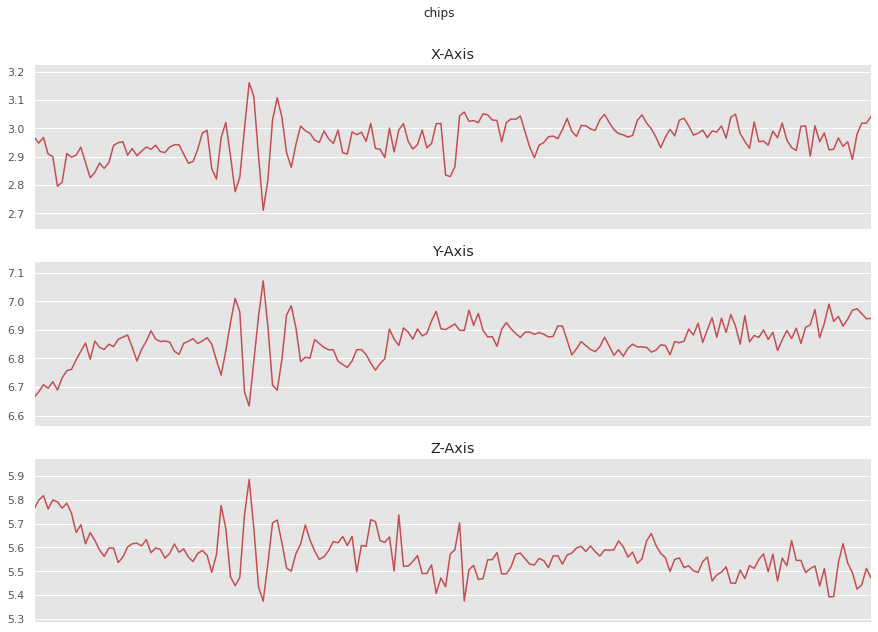

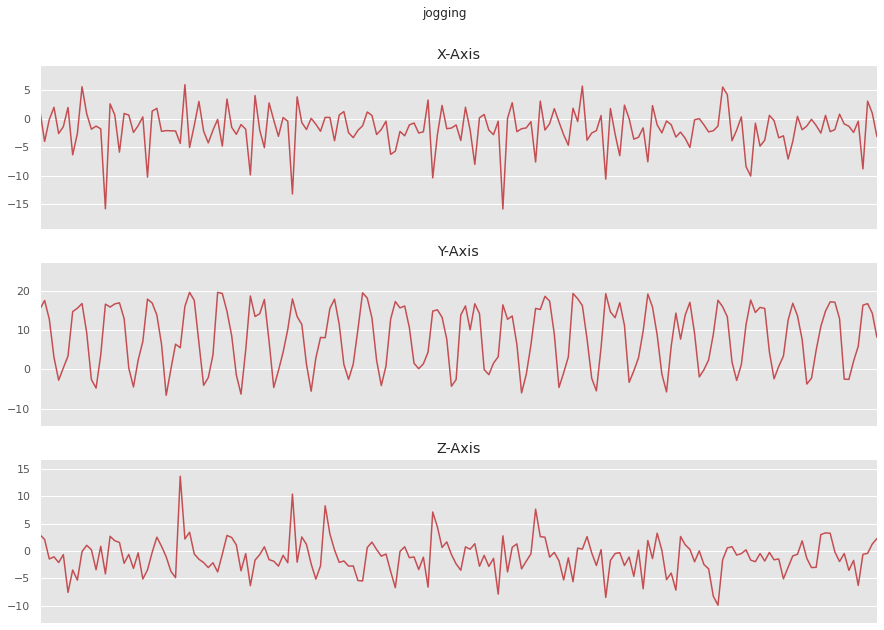

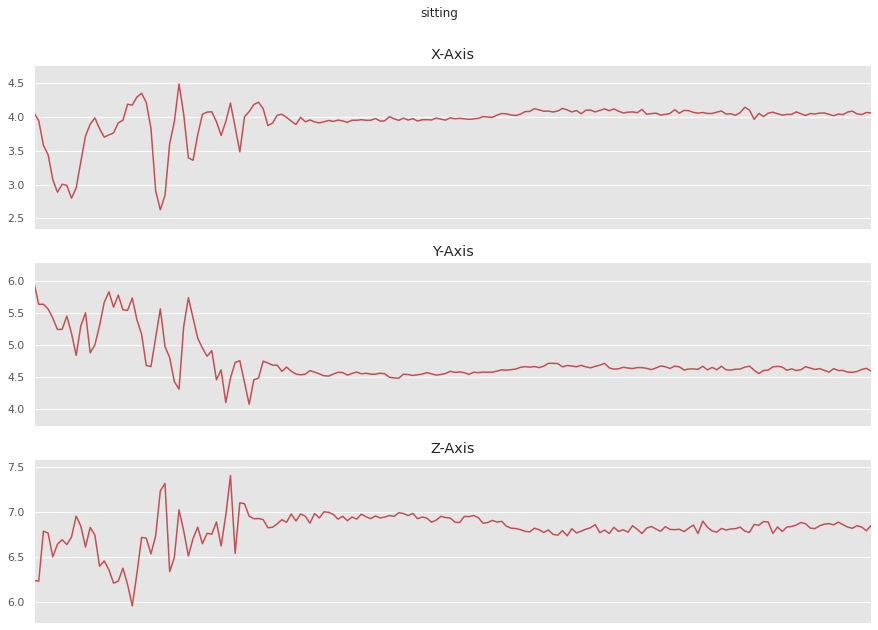

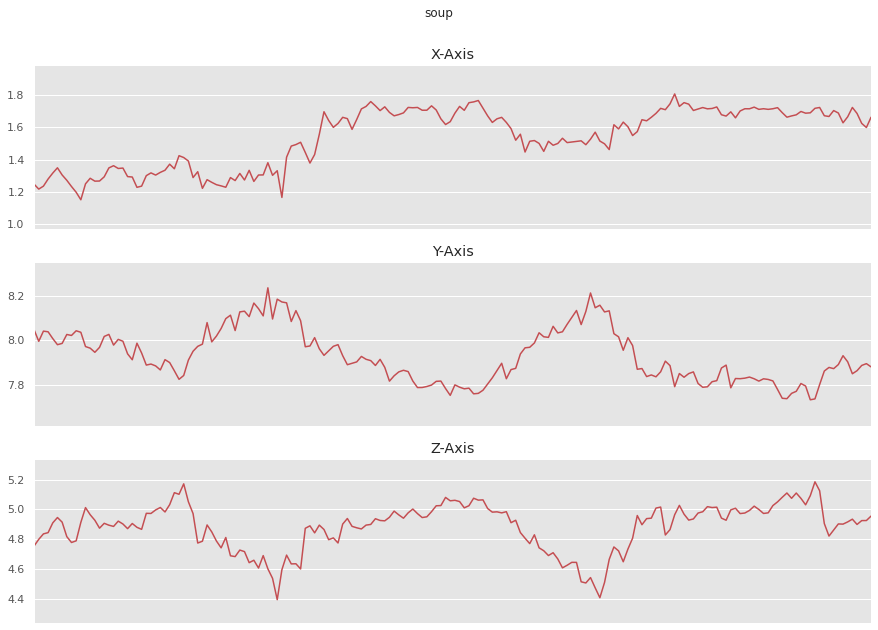

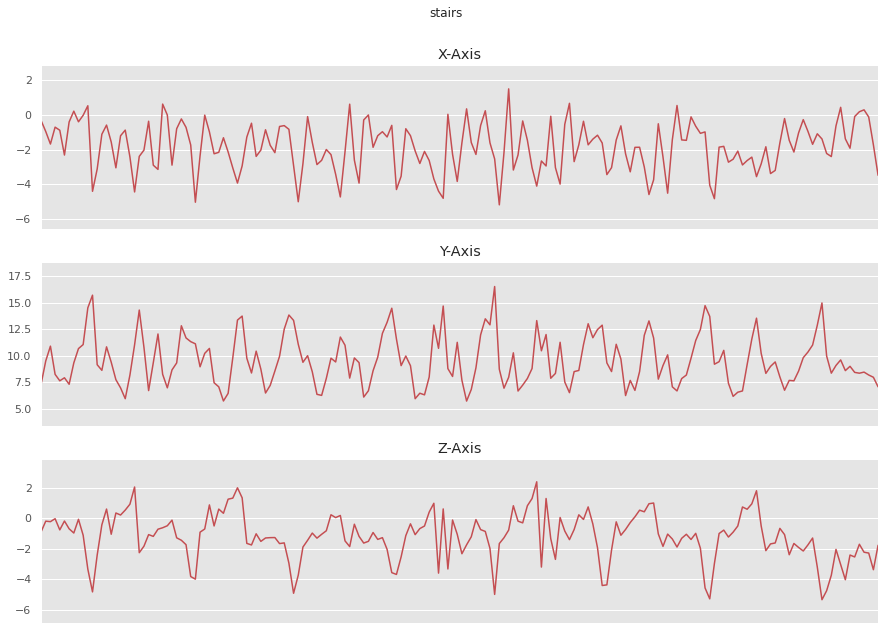

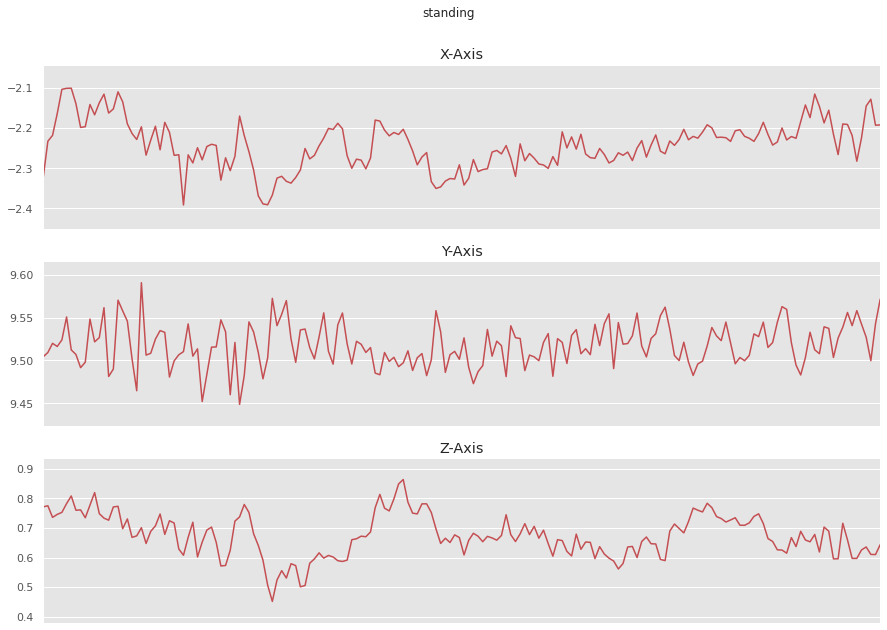

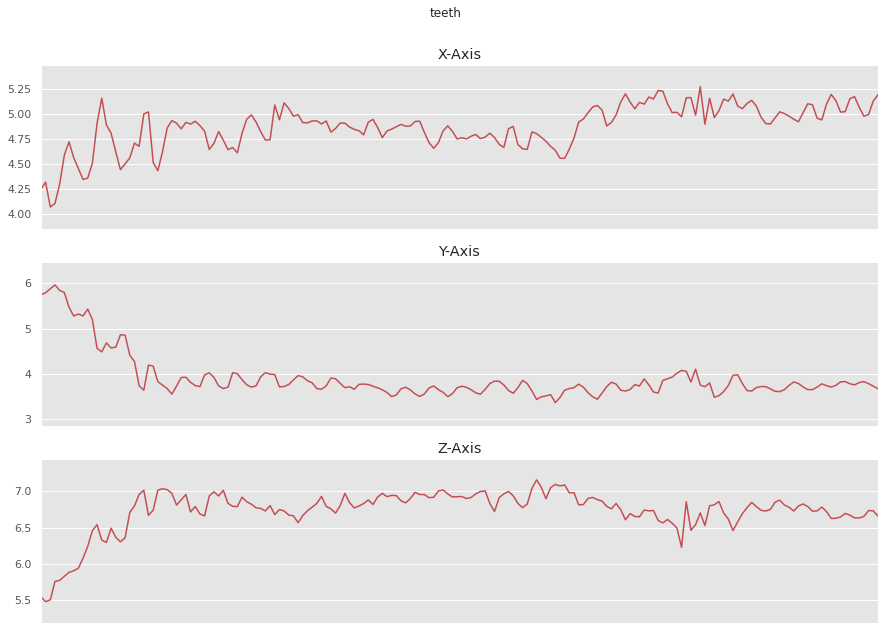

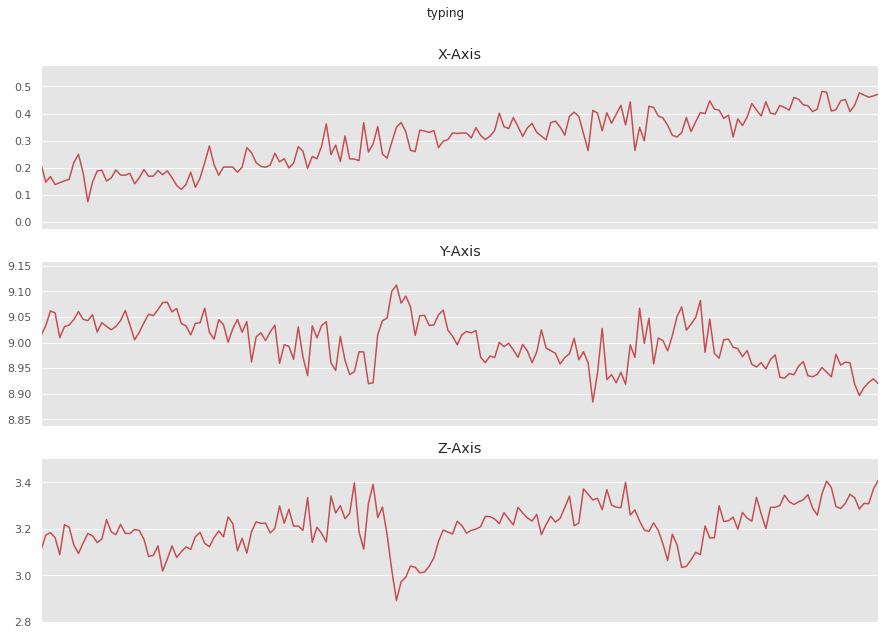

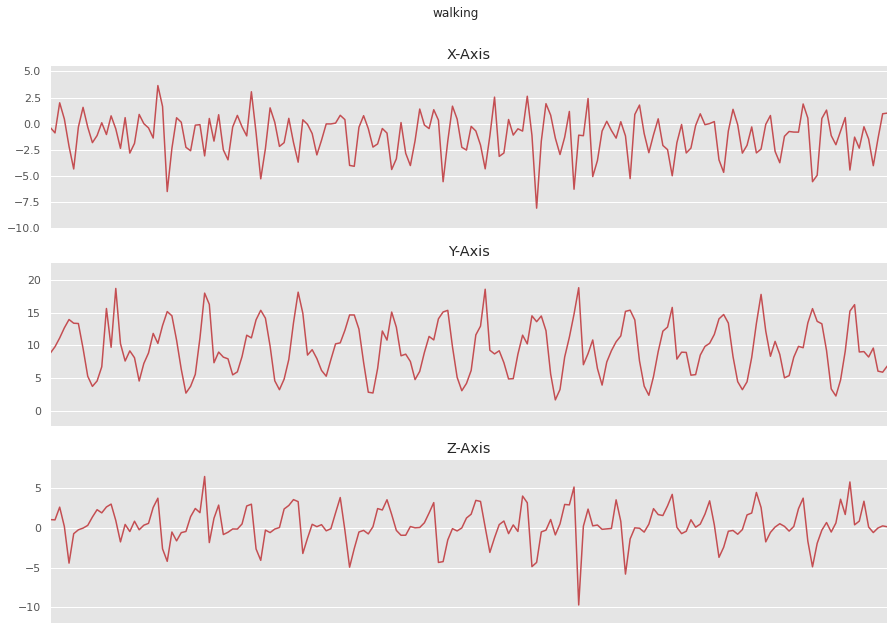

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# # Separate based of user id.
# base_activity= ['A','C','E','G','I','K','M','P','R']


# df_base = df[  (df['activity']=='A') | (df['activity']=='C') | (df['activity']=='E')
#              | (df['activity']=='G') | (df['activity']=='I') | (df['activity']=='K')
#              | (df['activity']=='M') | (df['activity']=='P') | (df['activity']=='R')]
# le = labelenocoder(df_base)
# Separate based of user id.

# try with 3 activities

# base_activity= ['typing','dribbling','walking']

# df_base = df[  (df['activity']=='typing') | (df['activity']=='dribbling') | (df['activity'] == 'walking')]


#try with 8 activities

# base_activity= ['walking', 'stairs', 'standing', 'teeth', 'chips', 'drinking', 'kicking',  'dribbling']


# df_base = df[  (df['activity']=='walking') | (df['activity']=='stairs') | (df['activity']=='standing')
#              | (df['activity']=='teeth') | (df['activity']=='chips') | (df['activity']=='drinking')
#              | (df['activity']=='kicking') | (df['activity']=='dribbling')]

#try with 15 activities

# base_activity= ['walking','jogging','stairs','sitting','standing','typing','teeth','soup','chips','pasta',
#                 'drinking','sandwich','kicking','catch','dribbling']

# df_base = df[  (df['activity']=='walking') | (df['activity']=='jogging') 
# | (df['activity'] == 'stairs') | (df['activity']=='sitting') | (df['activity']=='standing') | (df['activity'] == 'typing')
# | (df['activity'] == 'teeth') | (df['activity']=='soup') | (df['activity']=='chips') | (df['activity'] == 'pasta')
# | (df['activity'] == 'drinking') | (df['activity']=='sandwich') | (df['activity']=='kicking') | (df['activity'] == 'catch')
# | (df['activity'] == 'dribbling')]


# try with 9 activities
base_activity= ['walking','jogging','stairs','sitting','standing','typing','teeth','soup','chips']
df_base = df[  (df['activity']=='walking') | (df['activity']=='jogging') 
| (df['activity'] == 'stairs') | (df['activity']=='sitting') | (df['activity']=='standing') | (df['activity'] == 'typing')
| (df['activity'] == 'teeth') | (df['activity']=='soup') | (df['activity']=='chips')]
le = labelenocoder(df_base)

In [ ]:
LABEL = 'ActivityEncoded'
X_train,y_train = spliting_dataset(df_base)
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0,  stratify = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2,  random_state = 0, stratify = y_train)
X_train = X_train.reshape(len(X_train), 80, 3, 1)
X_val = X_val.reshape(len(X_val), 80, 3, 1)
X_test = X_test.reshape(len(X_test), 80, 3, 1)
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('X_val shape', X_val.shape)

X_train Shape: (17425, 80, 3)
17425 training samples
y_train shape:  (17425,)
input_shape: 240
['chips', 'jogging', 'sitting', 'soup', 'stairs', 'standing', 'teeth', 'typing', 'walking']
X_train:  (11152, 80, 3, 1)
X_test:  (3485, 80, 3, 1)
X_val shape (2788, 80, 3, 1)


In [ ]:
epochs = 1000
model,history,duration = fit_model(X_train, y_train, X_val, y_val,learning_rate=0.001,epochs=epochs)

Epoch 1/1000
88/88 [==============================] - 1s 8ms/step - loss: 1.3734 - accuracy: 0.4427 - val_loss: 1.0026 - val_accuracy: 0.5800
Epoch 2/1000
88/88 [==============================] - 0s 4ms/step - loss: 1.0204 - accuracy: 0.5732 - val_loss: 0.8849 - val_accuracy: 0.6144
Epoch 3/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.9081 - accuracy: 0.6176 - val_loss: 0.8028 - val_accuracy: 0.6431
Epoch 4/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.8463 - accuracy: 0.6437 - val_loss: 0.7917 - val_accuracy: 0.6664
Epoch 5/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.7787 - accuracy: 0.6727 - val_loss: 0.6826 - val_accuracy: 0.7346
Epoch 6/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.7030 - val_loss: 0.6570 - val_accuracy: 0.7371
Epoch 7/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.7239 - val_loss: 0.6117 - val_accuracy: 0.7604
Epoch 

In [ ]:
y_pred=model.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
# print(con_mat_norm)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = base_activity, 
                     columns = base_activity)

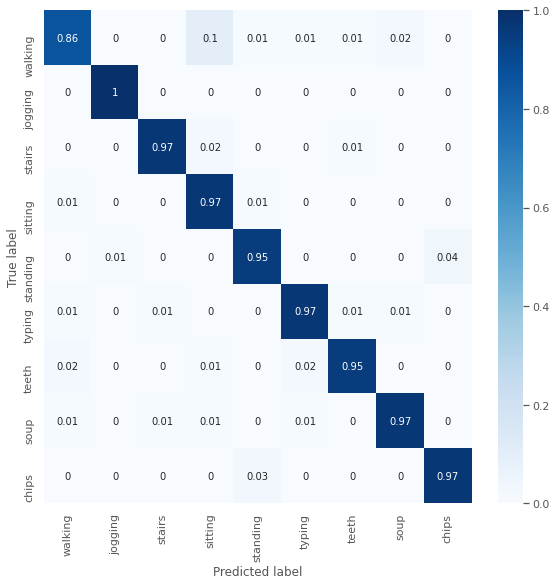

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.save('base_model.h5') 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


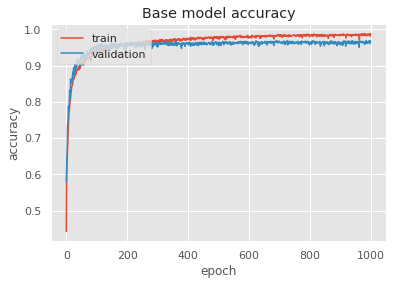

In [ ]:
print(history.history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('Base model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('base_model_accuracy.png')
plt.show()

# Transfer Learning For 5 activities

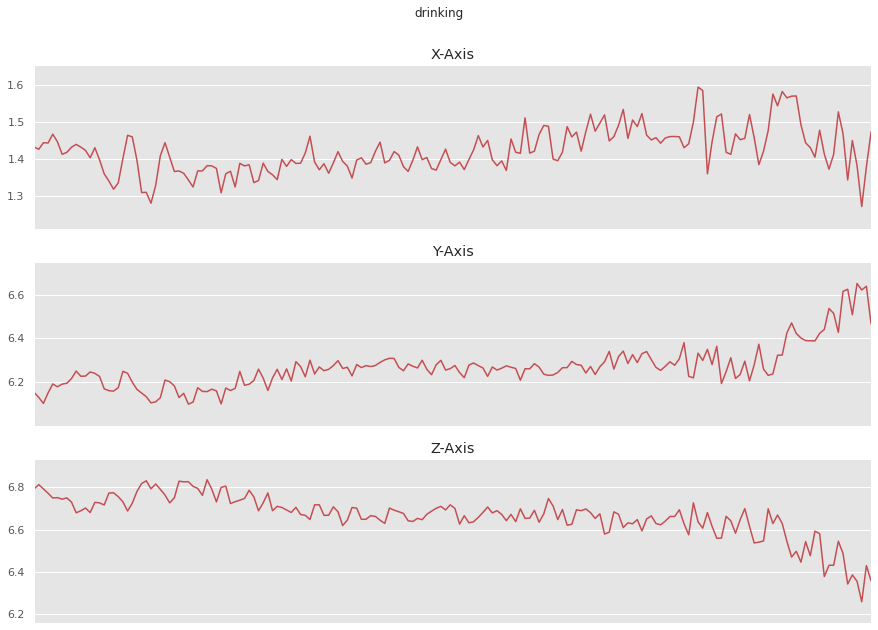

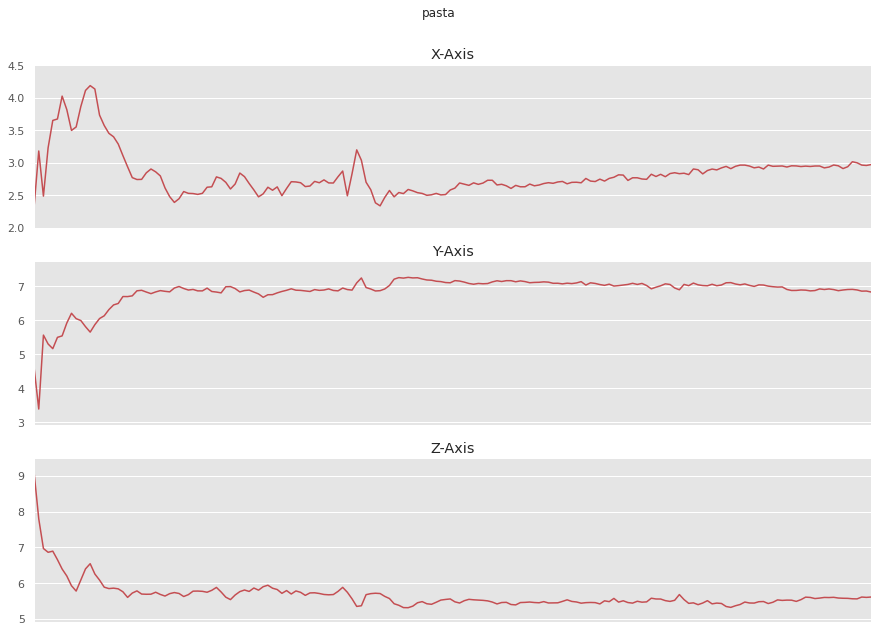

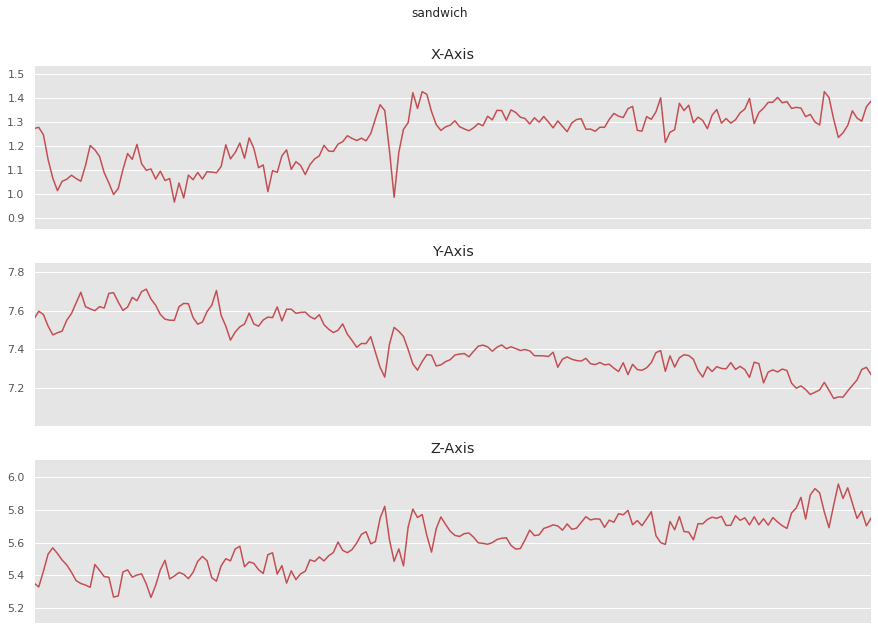

In [ ]:
# new_activity= ['B','D','F','H','J','L','O','Q','S']


# df_new = df[  (df['activity']=='B') | (df['activity']=='D') | (df['activity']=='F')
#              | (df['activity']=='H') | (df['activity']=='J') | (df['activity']=='L')
#              | (df['activity']=='O') | (df['activity']=='Q') | (df['activity']=='S')]
# le = labelenocoder(df_new)

# With 9 activities
# new_activity= ['jogging','sitting','typing','soup','pasta','sandwich','catch','writing','folding']


# df_new = df[  (df['activity']=='jogging') | (df['activity']=='sitting') | (df['activity']=='typing')
#              | (df['activity']=='soup') | (df['activity']=='pasta') | (df['activity']=='sandwich')
#              | (df['activity']=='catch') | (df['activity']=='writing') | (df['activity']=='folding')]

# With 3 activities

# new_activity= ['jogging','sitting','typing']
# df_new = df[ (df['activity']=='jogging') | (df['activity']=='sitting') | (df['activity']=='typing')]

# # With 2 activities
# new_activity= ['writing','clapping']
# df_new = df[ (df['activity']=='writing') | (df['activity']=='clapping')]

#With 3 activities
# new_activity= ['pasta','drinking','sandwich']
# df_new = df[ (df['activity']=='pasta') | (df['activity']=='drinking') | (df['activity']=='sandwich')]



# # With 5 activities
new_activity= ['writing','clapping','folding','catch','dribbling']
df_new = df[ (df['activity']=='writing') | (df['activity']=='clapping') | (df['activity']=='folding')
| (df['activity']=='catch') | (df['activity']=='dribbling')]

# With 4 activities
# new_activity= ['pasta','drinking','sandwich','kicking']
# df_new = df[ (df['activity']=='pasta') | (df['activity']=='drinking') | (df['activity']=='sandwich')
# | (df['activity']=='kicking')]

le = labelenocoder(df_new)

In [ ]:
X_train_new,y_train_new = spliting_dataset(df_new)

X_train Shape: (6078, 80, 3)
6078 training samples
y_train shape:  (6078,)
input_shape: 240


In [ ]:
num_time_periods, num_sensors = X_train_new.shape[1], X_train_new.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
# print(num_classes)

['drinking', 'pasta', 'sandwich']


In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2, random_state = 0,  stratify = y_train_new)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                  test_size = 0.2,  random_state = 0, stratify = y_train_new)

In [ ]:
X_train_new.shape, X_test_new.shape
X_test_new.shape

(1216, 80, 3)

In [ ]:
X_train_new = X_train_new.reshape(len(X_train_new), 80, 3, 1)
X_val_new = X_val_new.reshape(len(X_val_new), 80, 3, 1)
X_test_new = X_test_new.reshape(len(X_test_new), 80, 3, 1)
print('X_train: ',X_train_new.shape)
print('X_test: ',X_test_new.shape)
print('X_val shape', X_val_new.shape)

X_train:  (3889, 80, 3, 1)
X_test:  (1216, 80, 3, 1)
X_val shape (973, 80, 3, 1)


In [ ]:
# n_repeats = 8
# dists, dist_labels,durations = list(), list(),list()


In [ ]:
# ephos = 50
# standalone_scores, times = eval_standalone_model(X_train_new, X_test_new, y_train_new, y_test_new, X_val_new, y_val_new , n_repeats)
# print('Standalone %.3f (%.3f)' % (mean(standalone_scores), std(standalone_scores)))
# dists.append(standalone_scores)
# dist_labels.append('standalone')
# durations.append(times)
model = tf.keras.models.load_model('base_model.h5')
epochs = 300



# new line 

model.compile(optimizer=Adam(learning_rate = 0.001, decay = 1e-6
), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
history=model.fit(X_train_new,y_train_new,epochs=epochs,verbose=1,validation_data= (X_val_new, y_val_new))



# new_model,history_fine,duration = fit_model(X_train, y_train, X_val, y_val,epochs=epochs,learning_rate=0.001)

Epoch 1/300
122/122 [==============================] - 1s 5ms/step - loss: 10.4403 - accuracy: 0.3867 - val_loss: 1.5172 - val_accuracy: 0.6218
Epoch 2/300
122/122 [==============================] - 0s 3ms/step - loss: 1.3236 - accuracy: 0.5860 - val_loss: 0.7353 - val_accuracy: 0.6886
Epoch 3/300
122/122 [==============================] - 0s 3ms/step - loss: 0.8852 - accuracy: 0.6277 - val_loss: 0.6601 - val_accuracy: 0.7184
Epoch 4/300
122/122 [==============================] - 0s 3ms/step - loss: 0.7947 - accuracy: 0.6660 - val_loss: 0.5803 - val_accuracy: 0.7081
Epoch 5/300
122/122 [==============================] - 0s 3ms/step - loss: 0.7319 - accuracy: 0.6858 - val_loss: 0.5792 - val_accuracy: 0.7040
Epoch 6/300
122/122 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.7010 - val_loss: 0.5493 - val_accuracy: 0.7461
Epoch 7/300
122/122 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.7172 - val_loss: 0.4890 - val_accuracy: 0.744

In [ ]:
X_test_new,y_test_new=spliting_dataset(df_new)
X_test_new = X_test_new.reshape(len(X_test_new), 80, 3, 1)
y_pred_new=model.predict_classes(X_test_new)
con_mat1 = tf.math.confusion_matrix(labels=y_test_new, predictions=y_pred_new).numpy()
# print(con_mat1)

X_train Shape: (6078, 80, 3)
6078 training samples
y_train shape:  (6078,)
input_shape: 240


In [ ]:
con_mat_norm = np.around(con_mat1.astype('float') / con_mat1.sum(axis=1)[:, np.newaxis], decimals=2)
# print(con_mat_norm)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = new_activity, 
                     columns = new_activity)

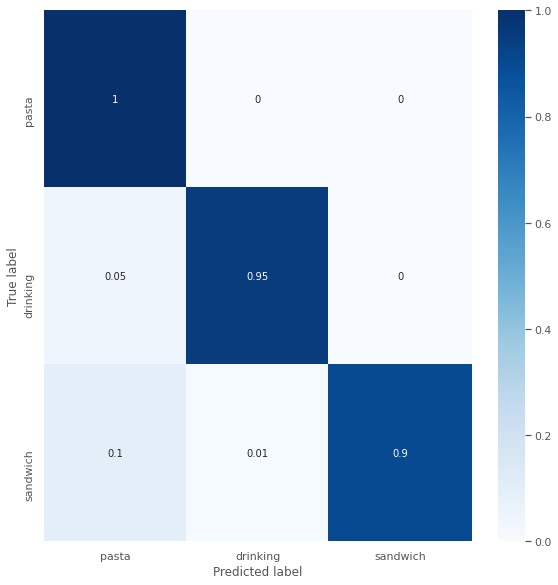

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.save('base_model_2.h5') 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


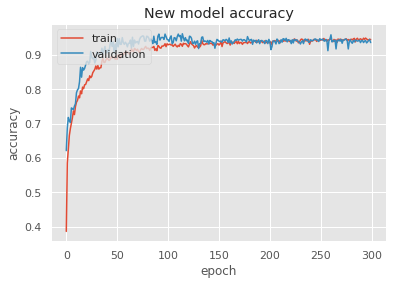

In [ ]:
print(history.history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('New model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('new_model_accuracy.png')
plt.show()

# Transfer Learning For 4 activities

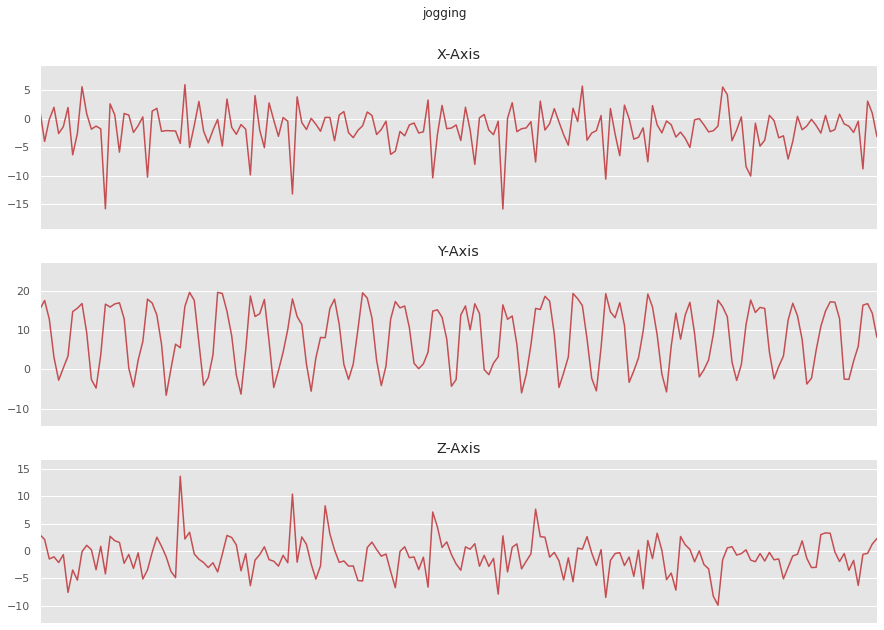

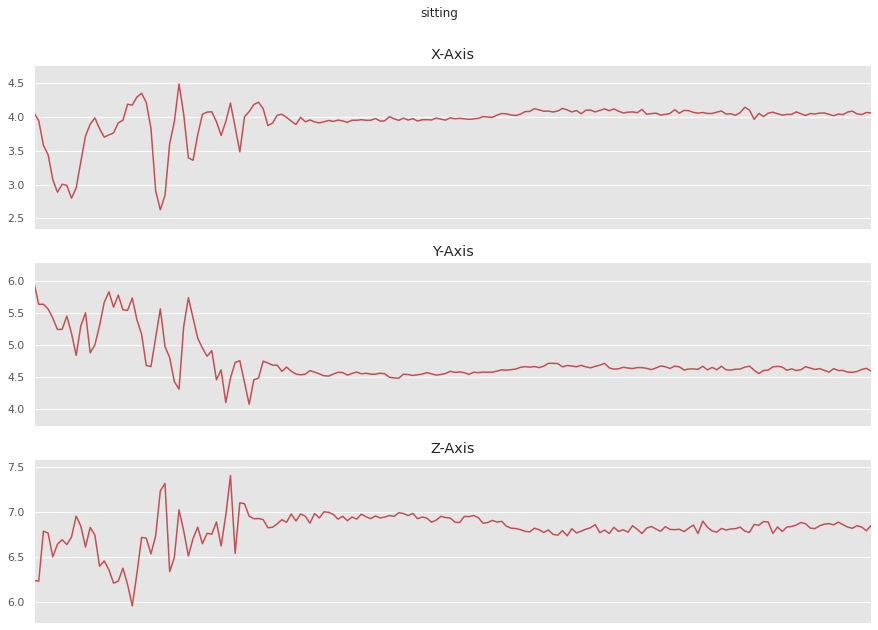

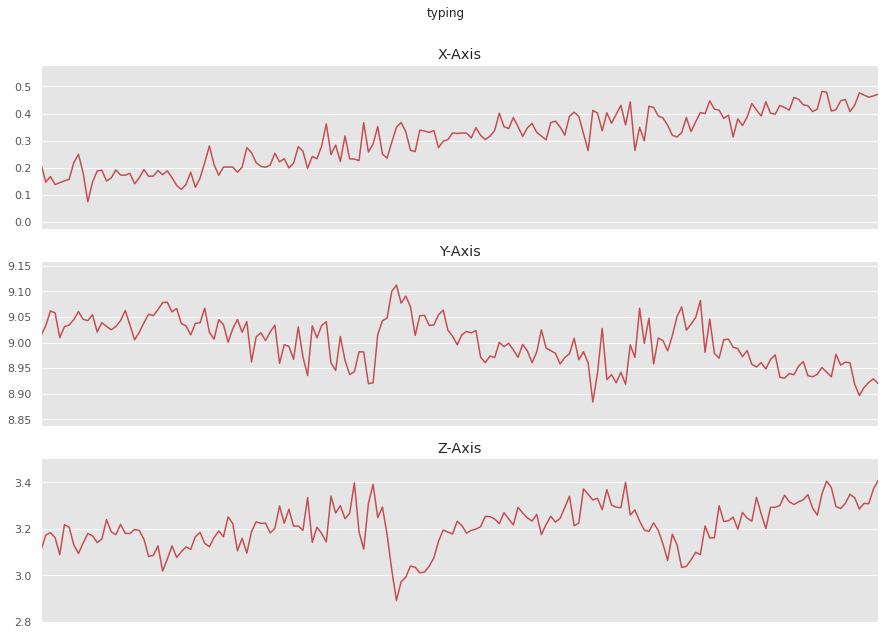

In [ ]:
# new_activity= ['B','D','F','H','J','L','O','Q','S']


# df_new = df[  (df['activity']=='B') | (df['activity']=='D') | (df['activity']=='F')
#              | (df['activity']=='H') | (df['activity']=='J') | (df['activity']=='L')
#              | (df['activity']=='O') | (df['activity']=='Q') | (df['activity']=='S')]
# le = labelenocoder(df_new)

# With 9 activities
# new_activity= ['jogging','sitting','typing','soup','pasta','sandwich','catch','writing','folding']


# df_new = df[  (df['activity']=='jogging') | (df['activity']=='sitting') | (df['activity']=='typing')
#              | (df['activity']=='soup') | (df['activity']=='pasta') | (df['activity']=='sandwich')
#              | (df['activity']=='catch') | (df['activity']=='writing') | (df['activity']=='folding')]

# With 3 activities

new_activity= ['jogging','sitting','typing']
df_new = df[ (df['activity']=='jogging') | (df['activity']=='sitting') | (df['activity']=='typing')]

# With 5 activities
# new_activity= ['writing','clapping','folding','catch','dribbling']
# df_new = df[ (df['activity']=='writing') | (df['activity']=='clapping') | (df['activity']=='folding')
# | (df['activity']=='catch') | (df['activity']=='dribbling')]

# # With 4 activities
# new_activity= ['pasta', 'drinking','sandwich','kicking']
# df_new = df[(df['activity']=='pasta') |(df['activity']=='drinking') | (df['activity']=='sandwich')
# | (df['activity']=='kicking')]

le = labelenocoder(df_new)

In [ ]:
X_train_new,y_train_new = spliting_dataset(df_new)

X_train Shape: (5474, 80, 3)
5474 training samples
y_train shape:  (5474,)
input_shape: 240


In [ ]:
num_time_periods, num_sensors = X_train_new.shape[1], X_train_new.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))
# print(num_classes)

['jogging', 'sitting', 'typing']


In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2, random_state = 0,  stratify = y_train_new)
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                  test_size = 0.2,  random_state = 0, stratify = y_train_new)

In [ ]:
X_train_new.shape, X_test_new.shape
X_test_new.shape

(1095, 80, 3)

In [ ]:
X_train_new = X_train_new.reshape(len(X_train_new), 80, 3, 1)
X_val_new = X_val_new.reshape(len(X_val_new), 80, 3, 1)
X_test_new = X_test_new.reshape(len(X_test_new), 80, 3, 1)
print('X_train: ',X_train_new.shape)
print('X_test: ',X_test_new.shape)
print('X_val shape', X_val_new.shape)

X_train:  (3503, 80, 3, 1)
X_test:  (1095, 80, 3, 1)
X_val shape (876, 80, 3, 1)


In [ ]:
# ephos = 50
# standalone_scores, times = eval_standalone_model(X_train_new, X_test_new, y_train_new, y_test_new, X_val_new, y_val_new , n_repeats)
# print('Standalone %.3f (%.3f)' % (mean(standalone_scores), std(standalone_scores)))
# dists.append(standalone_scores)
# dist_labels.append('standalone')
# durations.append(times)

#P3 Group # Tranfer Learning Model Apped 

model = tf.keras.models.load_model('base_model.h5')
epochs = 30
model.compile(optimizer=Adam(learning_rate = 0.0001, decay = 1e-6
), loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
history=model.fit(X_train_new,y_train_new,epochs=epochs,verbose=2,validation_data= (X_val_new, y_val_new))

# new_model,history_fine,duration = fit_model(X_train, y_train, X_val, y_val,epochs=epochs,learning_rate=0.001)

Epoch 1/30
22/22 - 0s - loss: 39.7936 - accuracy: 0.2003 - val_loss: 33.2610 - val_accuracy: 0.2717
Epoch 2/30
22/22 - 0s - loss: 32.5975 - accuracy: 0.2540 - val_loss: 26.3760 - val_accuracy: 0.3064
Epoch 3/30
22/22 - 0s - loss: 25.7338 - accuracy: 0.3149 - val_loss: 20.5231 - val_accuracy: 0.3468
Epoch 4/30
22/22 - 0s - loss: 21.6500 - accuracy: 0.3324 - val_loss: 16.2243 - val_accuracy: 0.4220
Epoch 5/30
22/22 - 0s - loss: 16.3405 - accuracy: 0.4078 - val_loss: 13.4579 - val_accuracy: 0.4913
Epoch 6/30
22/22 - 0s - loss: 14.6420 - accuracy: 0.4746 - val_loss: 11.3046 - val_accuracy: 0.5260
Epoch 7/30
22/22 - 0s - loss: 12.3281 - accuracy: 0.5007 - val_loss: 9.9653 - val_accuracy: 0.5549
Epoch 8/30
22/22 - 0s - loss: 11.2707 - accuracy: 0.5356 - val_loss: 8.8419 - val_accuracy: 0.5896
Epoch 9/30
22/22 - 0s - loss: 10.1315 - accuracy: 0.5327 - val_loss: 8.0270 - val_accuracy: 0.6243
Epoch 10/30
22/22 - 0s - loss: 9.2584 - accuracy: 0.5472 - val_loss: 7.2817 - val_accuracy: 0.6416
Epoc

In [ ]:
# for i in range(1,10):
#   history=model.fit(X_train_new,y_train_new,epochs=epochs,verbose=2,validation_data= (X_val_new, y_val_new))

In [ ]:
# model.

In [ ]:
X_test_new,y_test_new=spliting_dataset(df_new)
X_test_new = X_test_new.reshape(len(X_test_new), 80, 3, 1)
y_pred_new=model.predict_classes(X_test_new)
con_mat1 = tf.math.confusion_matrix(labels=y_test_new, predictions=y_pred_new).numpy()
# print(con_mat1)

X_train Shape: (8362, 80, 3)
8362 training samples
y_train shape:  (8362,)
input_shape: 240


In [ ]:
con_mat_norm = np.around(con_mat1.astype('float') / con_mat1.sum(axis=1)[:, np.newaxis], decimals=2)
# print(con_mat_norm)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = new_activity, 
                     columns = new_activity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(history.history.keys())
fig = plt.figure()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('Transfer model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
fig.savefig('base_model_accuracy.png')
plt.show()

# Different Sizes of Dataset


In [ ]:
# # With 4 activities
new_activity= ['pasta', 'drinking','sandwich','kicking']
df_new = df[(df['activity']=='pasta') |(df['activity']=='drinking') | (df['activity']=='sandwich')
| (df['activity']=='kicking')]

le = labelenocoder(df_new)
# print(df_new)

In [ ]:
df_new = pd.DataFrame(df_new)
data_set=[]
for i in range(10):
  data_size=int(df_new.shape[0]/(10*(i+1)))
  frames=[]
  for i in range(len(new_activity)):
    frames.append(df_new[df_new['activity']==new_activity[i]][:data_size])
  # smallSize_df = pd.concat(frames)
  data_set.append(pd.concat(frames))
  # print(data_set[1].shape)


In [ ]:
# DatasetList=[]
# for i in range(10):
#   DatasetList.append(data_set[i].shape[0])
  
# print("Different dataset size",DatasetList)


In [ ]:
accuracyList=[]
DatasetList=[]

for i in range(10):
  X_train_new,y_train_new = spliting_dataset(data_set[i])
  # print("X_train_new",X_train_new.shape[0])
  DatasetList.append(X_train_new.shape[0])
  num_time_periods, num_sensors = X_train_new.shape[1], X_train_new.shape[2]
  num_classes = le.classes_.size
  print(list(le.classes_))
  X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_new, y_train_new, 
                                                                      test_size = 0.2, random_state = 0,  stratify = y_train_new)
  X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, 
                                                                    test_size = 0.2,  random_state = 0, stratify = y_train_new)
  X_train_new.shape, X_test_new.shape
  X_test_new.shape
  X_train_new = X_train_new.reshape(len(X_train_new), 80, 3, 1)
  X_val_new = X_val_new.reshape(len(X_val_new), 80, 3, 1)
  X_test_new = X_test_new.reshape(len(X_test_new), 80, 3, 1)
  print('X_train: ',X_train_new.shape)
  print('X_test: ',X_test_new.shape)
  print('X_val shape', X_val_new.shape)
  model = tf.keras.models.load_model('base_model.h5')
  epochs = 50
  model.compile(optimizer=Adam(learning_rate = 0.001, decay = 1e-6
  ), loss = 'sparse_categorical_crossentropy', 
                metrics = ['accuracy'])
  history=model.fit(X_train_new,y_train_new,epochs=epochs,verbose=1,validation_data= (X_val_new, y_val_new))

  accuracyList.append(history.history['accuracy'][-1])

In [ ]:
print("Different datasets size",DatasetList)

In [ ]:
# print(accuracyList)
fig = plt.figure()
DatasetList.reverse()
accuracyList.reverse()
print(accuracyList)
print(DatasetList)
# summarize history for accuracy
plt.plot(DatasetList,accuracyList)
plt.title('Trasnfer Learning model accuracy')
plt.ylabel('accuracy')
plt.xticks(rotation=45)
plt.xlabel('Amount of data')
plt.legend(['accuracy'], loc='upper left')
plt.show()

In [ ]:
# from numpy import mean
# from numpy import std
# from matplotlib import pyplot
# n_fixed = 3
# n_repeats =3
# dists, dist_labels,durations = list(), list(),list()
# for i in range(n_fixed):
#     scores,times = eval_transfer_model(X_train_new,  X_test_new, y_train_new, y_test_new , i, n_repeats)
#     print('Transfer (fixed=%d) %.3f (%.3f)' % (i, mean(scores), std(scores)))
#     dists.append(scores)
#     dist_labels.append('transfer f='+str(i))
#     durations.append(times)
 
# box and whisker plot of score distributions


In [ ]:
# fig = pyplot.figure(figsize=(10,10))
# pyplot.title('Transfer Learning Layerwise')
# plt.ylabel('Accuracy')
# pyplot.boxplot(dists, labels=dist_labels)
# fig.savefig('boxplot_tranferleraning.png')
# pyplot.show()

In [ ]:
# t = list()
# for i in durations:
#     t.append(float(mean(i)/60))

In [ ]:
# fig = plt.figure(figsize=(12,12))
# y_pos = np.arange(len(dist_labels))
# plt.bar(y_pos, t, align='center', alpha=0.5)
# plt.title('Durantion of training')
# plt.ylabel('Time (min)')
# plt.xticks(y_pos,dist_labels)
# plt.xlabel('Fixed layers')
# fig.savefig('duration_tranferlearning.png')
# plt.show()

In [ ]:
# print(scores)